In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),"packages"))
print os.getcwd()
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import pandas as pd
import getimage
#import geocoder
import reverse_geocoder as rg # Offline geocoder
import conversion
import improcess
import seaborn as sns; #sns.set()
reload(getimage)
reload(improcess)
import warnings
warnings.filterwarnings('ignore')

/Users/shijia/Documents/@UCSD/Courses/Spring2018/ECE143/night-flare


**Demo for `get_image()` in getimage module**

(512, 512)
The Raw Light Pollution Map in Oregon Area


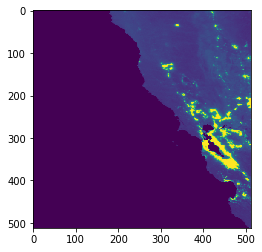

In [2]:
im = getimage.get_image(tileMatrix=6, tileCol=12, tileRow=11, date="2017-10-10") #Oregon Area
im = np.array(im)
print (im.shape)
plt.imshow(im)
print "The Raw Light Pollution Map in Oregon Area"

### How to Decode Geographic Location Information
[reverse-geocoder Documentaion](https://github.com/thampiman/reverse-geocoder) (Offline Geodecoder)

```python
import reverse_geocoder as rg

coordinates = (32.874,-117.223)#, (32.765370, -117.023632)#,(9.936033, 76.259952),(37.38605,-122.08385)
results = rg.search(coordinates)
print results[0]```

[Geocoder Documentation](http://geocoder.readthedocs.io/api.html#install)


```python
import geocoder
geocoder.google("453 Booth Street, Ottawa ON").housenumber```


Explanation on the parameters:

* tileMatrix: Zoomed in level
* tileCol: Column index in the map tiles
* tileRow: Row index in the map tiles
* improcess_select: To select between 'band-reject' and 'clip' image processing method.

### Analysis on the top-10 most light polluted counties in California

To obtain the Light Pollution Map by providing the latitude and longtitude

In [3]:
reload(improcess)
# To obtain the whole california state light pollution map (After Image Processing) in April, 2018.
# Might take 15s to run
tileMatrix = 6
latitude, longtitude = (41.802756, -123.979162) # Top Left Conner of the Califonia Region
tileRow, tileCol = conversion.get_tile_info(latitude=41.802756, longtitude=-123.979162, tileMatrix=6)
print('tileRow = {}, tileCol = {}, tileMatrix = {}'.format(tileRow, tileCol, tileMatrix))
improcess_select = 'band_reject'
im, mask = improcess.get_california_image(tileMatrix=6, tileCol=12, tileRow=10, start_date="2018-04-01", num_days=31,
                                          improcess_select=improcess_select)

tileRow = 10, tileCol = 12, tileMatrix = 6


To display the light pollution map and the mask for land

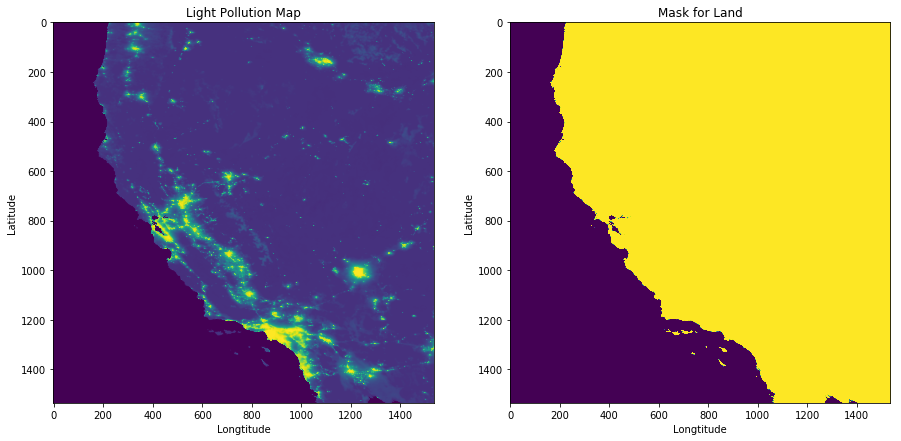

In [4]:
plt.figure(figsize=(15,15))

plt.figure(1)
plt.subplot(121)
plt.imshow(im)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('Light Pollution Map')
plt.subplot(122)
plt.imshow(mask)
    
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('Mask for Land')
plt.savefig(os.getcwd() + '/images/201804_pollution_mask_CA.png')
plt.show()

**To perform geodecoding on the light pollution map and convert the results to pandas DataFrame for analysis**

Up to this point, all the data we have are image files. In order to get insights on our dataset, we first need to convert the image files to tables or spreadsheets format using pandas DataFrame. 

We used the upper left corner coordinates and the zoom in level to get the longtitude and latitude information for each pixel location. Then we apply the geodecoder process to get corresponding geographic information, such as administration name, region, county, country name by utilizing the third-party geodecoder library(reverse-geocoder ). The reason for using this library instead of Google Map API is reverse-geocoder allows the user to perform the offline geodecoding which speed up the decoding process. Next, we filter out the non-California region and the ocean region geo information based on the mask obtained along with the `get_california_map()` function. Finally, we stored all the geo information into pandas DataFrame for later anlysis.



In [5]:
%%time
# Takes 30s to run
reload(conversion)
df_cali = conversion.geodecode_region(tileMatrix, tileCol, tileRow, im, mask, state='California')
print "The total pixel locations in California, US: ", df_cali['Light Pollution'].count()
#df_cali.to_csv('201804_light_pollution_CA.csv', sep=',')

Loading formatted geocoded file...
The total pixel locations in California, US:  523944
CPU times: user 16.1 s, sys: 887 ms, total: 17 s
Wall time: 19.2 s


Text(0.5,0,'Light Pollution Level')

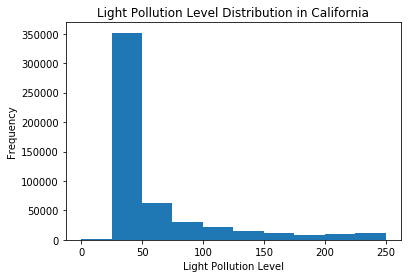

In [6]:
df_cali['Light Pollution'].plot('hist')
plt.title('Light Pollution Level Distribution in California')
plt.xlabel('Light Pollution Level')

**The table below is a sample DataFrame we created displaying only the first five rows of geo information.**

In [7]:
df_cali.head(n=5)

,Light Pollution,Region,County,State,Country,Region Coordinate,Latitude,Longtitude
0,35.975733,Tulelake,Siskiyou County,California,US,"(41.95599, -121.47749)",42.662109,-121.042969
1,35.978937,Tulelake,Siskiyou County,California,US,"(41.95599, -121.47749)",42.662109,-121.034180
2,35.982146,Tulelake,Siskiyou County,California,US,"(41.95599, -121.47749)",42.653320,-121.051758
3,35.984084,Tulelake,Siskiyou County,California,US,"(41.95599, -121.47749)",42.653320,-121.042969
4,35.986867,Tulelake,Siskiyou County,California,US,"(41.95599, -121.47749)",42.653320,-121.034180


In [8]:
stats = df_cali['Light Pollution'].groupby(df_cali['County']).describe()
stats.sort_values(by=['mean'], ascending=False, inplace=True)
stats['Total Light Pollution Count'] = stats['count'] * stats['mean']

**The table showed below demonstrates the statistics and is organized by the mean of the average light pollution level**

In [9]:
stats.head(n=10)

,count,mean,std,min,25%,50%,75%,max,Total Light Pollution Count
County,,,,,,,,,
San Francisco County,124.0,200.295189,75.106261,3.539622,206.709433,238.747403,243.844958,248.619531,2.483660e+04
Orange County,2936.0,199.185567,51.362473,3.275589,166.444453,218.169932,240.854342,249.765131,5.848088e+05
Alameda County,2173.0,169.964793,55.860783,2.399937,131.346464,174.318860,222.026971,247.592043,3.693335e+05
Sacramento County,3859.0,147.576715,59.595019,59.358368,94.593919,132.859034,212.398459,248.937945,5.694985e+05
Los Angeles County,12617.0,147.442248,76.620515,3.947309,73.668400,137.538523,232.667862,249.801096,1.860279e+06
Contra Costa County,3458.0,143.755070,47.132890,3.007105,101.683635,143.286073,180.041645,241.024304,4.971050e+05
San Mateo County,1775.0,132.479991,63.741830,2.874377,76.843864,125.238814,191.259704,246.268932,2.351520e+05
San Joaquin County,5121.0,127.051528,49.156654,34.139224,94.619881,123.640180,155.299776,242.006063,6.506309e+05
Santa Clara County,4300.0,121.435809,68.811643,32.999381,62.784552,101.282714,181.752702,247.034317,5.221740e+05


**The plot below demonstrated the top-10 light polluted counties in California based on the average light pollution level**

In [10]:
sns.set() # Set the style of the plot

Text(0,0.5,'Average Light Pollution')

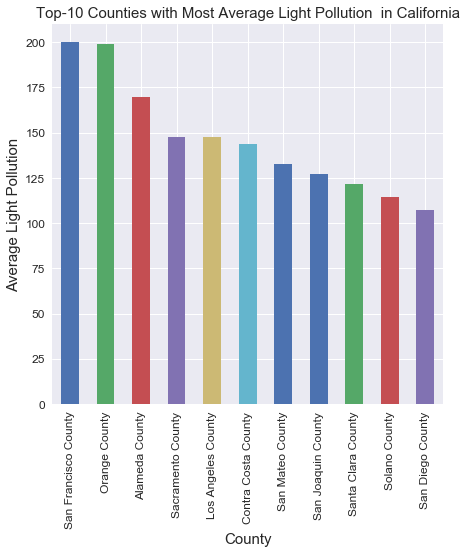

In [11]:
cali_mean = df_cali.groupby(['County'])['Light Pollution'].mean()
cali_mean.sort_values(ascending=False).head(n=11).plot(kind='bar', 
                                                       figsize=(7,7), 
                                                       fontsize=12)
plt.title('Top-10 Counties with Most Average Light Pollution  in California', fontsize=15)
plt.xlabel('County', fontsize=15)
plt.ylabel('Average Light Pollution', fontsize=15)

**The plot below demonstrated the top-10 counties with most total light pollution in California based on the average light pollution level**

Text(0,0.5,'Total Light Pollution Count')

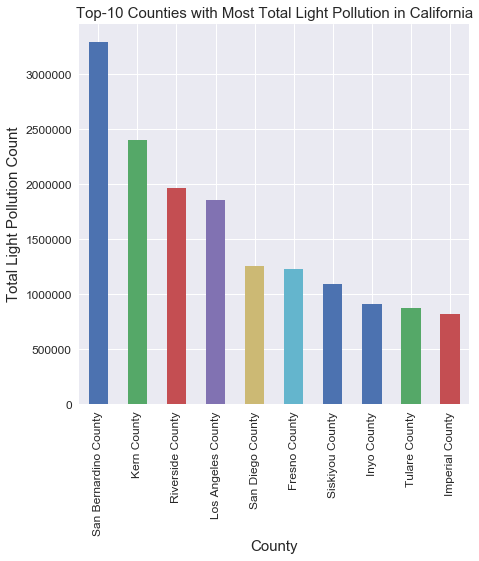

In [12]:
cali_total = stats['Total Light Pollution Count'].sort_values(ascending=False).head(10)
cali_total.plot(kind='bar', 
                figsize=(7,7), 
                fontsize=12)
plt.title('Top-10 Counties with Most Total Light Pollution in California', fontsize=15)
plt.xlabel('County', fontsize=15)
plt.ylabel('Total Light Pollution Count', fontsize=15)

Text(0,0.5,'Total Light Pollution Count')

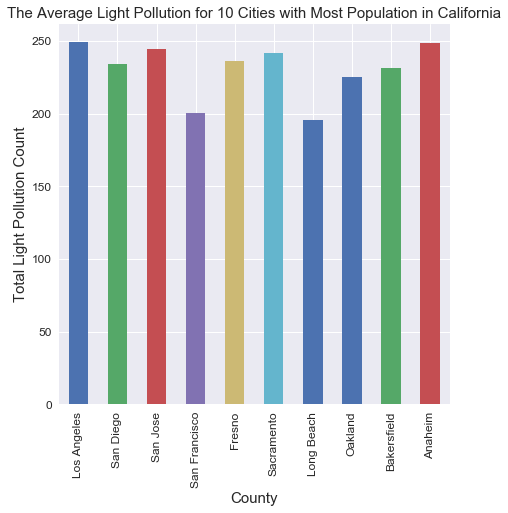

In [13]:
cali_region_mean = df_cali.groupby(['Region'])['Light Pollution'].mean().sort_values(ascending=False)
city_list = ['Los Angeles', 'San Diego','San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach',
            'Oakland', 'Bakersfield', 'Anaheim']
cali_region_mean.loc[city_list].plot(kind='bar', 
                                     figsize=(7,7), 
                                     fontsize=12)
plt.title('The Average Light Pollution for 10 Cities with Most Population in California', fontsize=15)
plt.xlabel('County', fontsize=15)
plt.ylabel('Total Light Pollution Count', fontsize=15)

We define the pixel intensity level higher than 220 as the region suffers from series light pollution

Text(0.5,1,'Top-10 Counties with High Light Pollution Percentage over the Area')

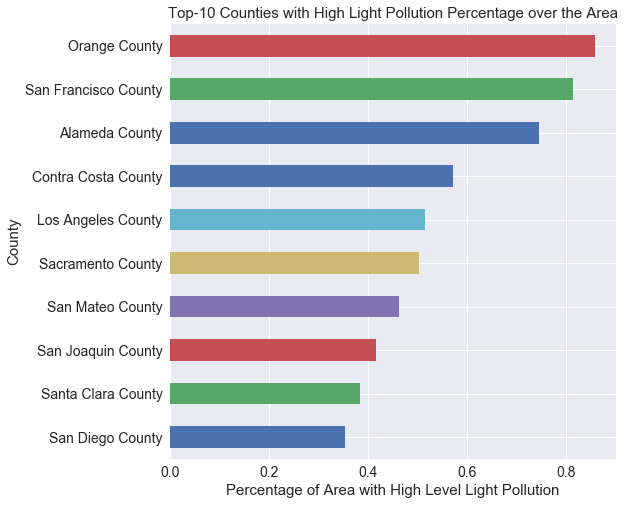

In [14]:
df_cali_tmp = df_cali.copy()
thresh = df_cali['Light Pollution'].quantile(0.9)
df_cali_tmp['High'] = df_cali_tmp['Light Pollution'].apply(lambda x: (x > thresh) * 1)
df_cali_tmp = df_cali_tmp.groupby("County")['High'].sum() / df_cali_tmp.groupby("County")['High'].count()
ax=df_cali_tmp.sort_values(ascending=False).head(n=10).sort_values(ascending=True).plot('barh', figsize=(8,8),fontsize=14)
plt.xlabel('Percentage of Area with High Level Light Pollution', fontsize=15)
plt.ylabel('County', fontsize=15)
plt.title('Top-10 Counties with High Light Pollution Percentage over the Area', fontsize=15)

### Analysis of Monthly Average Light Pollution Trend for Major Cities in California

In [15]:
reload(conversion)
reload(getimage)
num_months = 13
month = 1
year = 2017
city_list = ['Los Angeles', 'San Diego','San Jose', 'San Francisco', 'Fresno', 'Sacramento', 'Long Beach',
            'Oakland', 'Bakersfield', 'Anaheim', 'La Jolla', 'Irvine', 'San Bernardino', 'Riverside', 'Santa Barbara']
df = pd.DataFrame()
df_mean_trend = pd.DataFrame()
tileMatrix=6
tileCol=12
tileRow=10
for n in range(num_months):
    start_date = "{0}-{1:02d}-01".format(year, month)
    file_name = os.getcwd() + "/data/" + start_date + "_major_cities.csv"
    if not os.path.isfile(file_name):
        im, mask = improcess.get_california_image(tileMatrix=6, tileCol=12, tileRow=10, start_date=start_date, num_days=30)
        df_tmp = conversion.geodecode_region(tileMatrix, tileCol, tileRow, im, mask, city=city_list)
        series_mean = df_tmp.groupby(['Region'])['Light Pollution'].mean()
        df_mean = series_mean.reset_index()
        df_mean['Time'] = "{0}-{1:02d}".format(year, month)
        df_mean.to_csv(file_name)
        df = df.append(df_mean)
    else:
        df_tmp = pd.read_csv(file_name)
        df = df.append(df_tmp)
        
    print start_date, "Finished."
    #print df_mean
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1
    

2017-01-01 Finished.
2017-02-01 Finished.
2017-03-01 Finished.
2017-04-01 Finished.
2017-05-01 Finished.
2017-06-01 Finished.
2017-07-01 Finished.
2017-08-01 Finished.
2017-09-01 Finished.
2017-10-01 Finished.
2017-11-01 Finished.
2017-12-01 Finished.
2018-01-01 Finished.


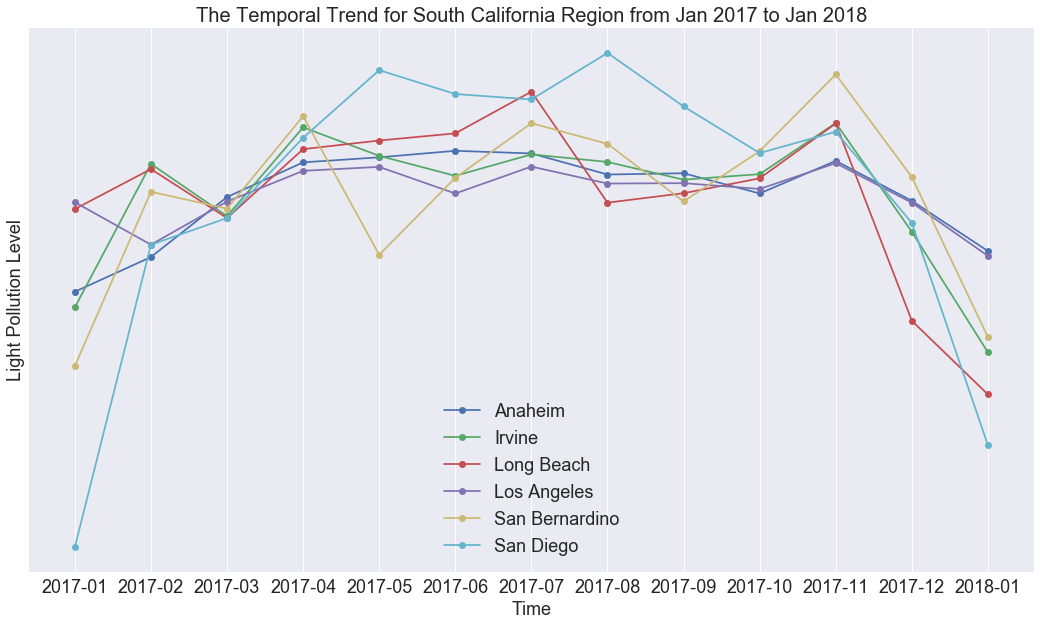

In [16]:
start_date = "{0}-{1:02d}-01".format(year, 12)
grouped = df.groupby(['Region'])

south_california = ['Los Angeles', 'San Diego', 'Long Beach', 'Anaheim', 'San Bernardino', 'Irvine']
fig, ax = plt.subplots()
# ['Los Angeles', 'San Diego', 'Sacramento', 'Long Beach']
for name, group in grouped:
    if name in south_california:
        tmp = group.rename(columns={'Light Pollution': name})
        tmp = tmp.groupby('Time').first()[name]
        tmp = tmp / tmp.mean()
        tmp.plot(ax=ax, figsize=(18,10), fontsize=18, legend=True, kind='line', marker='o')
        plt.legend(prop={'size': 18})
        ax.set_xticks(range(num_months))
        ax.set_yticks([])
        plt.ylabel('Light Pollution Level', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        #print group.groupby('Time').first()['Light Pollution']
plt.title('The Temporal Trend for South California Region from Jan 2017 to Jan 2018', fontsize=20)
plt.show()

### Analysis on the correlation between different factors and the light pollution level

* Population Density
* Electricity Consumption
* Economic Regions

Load the dataset for population census in different counties

In [17]:
# Process population dataset
df_population = pd.read_csv(os.getcwd() + '/data/county_population.csv', header=None, names=['County', 'Population'])
df_population.drop(0, inplace=True)
df_population.reset_index(inplace=True)
df_population.drop('index', axis=1,inplace=True)
df_population['County'] = df_population['County'].apply(lambda x: x + ' County')
df_population['Population']=df_population['Population'].apply(lambda x: int(x))
df_population.head()

,County,Population
0,Alameda County,1646405
1,Alpine County,1156
2,Amador County,38382
3,Butte County,226403
4,Calaveras County,45175


In [18]:
df_light_county = df_cali.groupby('County')['Light Pollution'].sum()
df_light_county = df_light_county.reset_index()[['County', 'Light Pollution']]
df_light_county = pd.merge(df_light_county, df_population, on='County')

To demonstrate the correlation between the population density and light pollution level.

We can find positive correlation between the light pollution and population density in different counties. The higher the population a county has, the higher the total light pollution amount. However, the correlation is not too strong.

In [ ]:
from numpy.polynomial.polynomial import polyfit
x = df_light_county['Population']
y = df_light_county['Light Pollution']

plt.figure(figsize=(10,8))
b, m = polyfit(np.log(x), np.log(y), 1)
#plt.plot(np.log(x), np.log(y), '.')
plt.loglog(x, y, 'o')
plt.loglog(x, np.exp(b + m * np.log(x)), '-')
plt.title('The Correlation Between Light Pollution Level and Population for Counties in California', fontsize=15)
plt.xlabel('Population', fontsize=15)
plt.ylabel('Total Light Pollution', fontsize=15)
plt.show()

**Population VS light pollution level for cities**

There is no clear correlation between the population and the light pollution level for different cities

In [ ]:
df_city_population = pd.read_csv(os.getcwd() + '/data/city_population.csv')
df_city_population.drop(['Land area', 'Type','Incorporated'], axis=1, inplace=True)
df_city_population.rename(index=str, columns={"Population (2010)": "Population", "Name": "Region"}, inplace=True)
df_city_population['Population']=df_city_population['Population'].apply(lambda x: int(x))

In [ ]:
%matplotlib inline
fig,ax = plt.subplots()
df_tmp = df_cali.groupby('Region')['Light Pollution'].sum()
df_tmp = df_tmp.reset_index()[['Region', 'Light Pollution']]
df_tmp = pd.merge(df_tmp, df_city_population, on='Region')
df_tmp.plot(ax=ax, kind='scatter', x='Population', y='Light Pollution', figsize=(8,8), loglog=True)
plt.xlabel('Population', fontsize=15)
plt.ylabel('Light Pollution', fontsize=15)
plt.title('The Correation between City Population and Total Light Pollution Level', fontsize=15)
plt.show()

Load the dataset for electricity consumption by different counties

In [ ]:
df_electricity = pd.read_csv(os.getcwd() + '/data/electricity_county.csv')
df_electricity['County'] = df_electricity['County'].apply(lambda x: x.title() + " County")
df_electricity = df_electricity.loc[(df_electricity['Sector'] == 'Total')].reset_index()
df_electricity = df_electricity[['County', 'Sector', '2009']]
df_electricity.rename(index=str, columns={'2009': "Electricity Consumption"}, inplace=True)

To demonstrate the correlation between the light pollution level and the electricity consumption in different counties

We can also observe positive correlation between light pollution and electricity consumption, but not too strong. The higher the consumption, the higher the light pollution level. 

In [ ]:
df_total_light_pollu = df_cali.groupby('County')['Light Pollution'].sum().reset_index()
electricity_pollution = pd.merge(df_electricity, df_total_light_pollu, on='County')
x = electricity_pollution['Electricity Consumption']
y =  electricity_pollution['Light Pollution']
plt.figure(figsize=(10,8))
b, m = polyfit(np.log(x), np.log(y), 1)
#plt.plot(np.log(x), np.log(y), '.')
plt.loglog(x, y, 'o')
plt.loglog(x, np.exp(b + m * np.log(x)), '-')
plt.title('The Correlation Between Light Pollution Level and Electricity Consumption for Counties in California', fontsize=14)
plt.xlabel('Electricity Consumption (GWh)', fontsize=15)
plt.ylabel('Total Light Pollution', fontsize=15)
plt.show()

To demonstrate the correlation between the Population and Electricity Consumption

There is an obvious positive and strong correlation between the population density and electricity consumption.

In [ ]:
population_electricity = pd.merge(electricity_pollution, df_light_county, on='County')
x = population_electricity['Electricity Consumption']
y =  population_electricity['Population']
plt.figure(figsize=(10,8))
b, m = polyfit(np.log(x), np.log(y), 1)
#plt.plot(np.log(x), np.log(y), '.')
plt.loglog(x, y, 'o')
plt.loglog(x, np.exp(b + m * np.log(x)), '-')
plt.title('The Correlation Between Population and Electricity Consumption for Counties in California', fontsize=14)
plt.xlabel('Electricity Consumption (GWh)', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.show()

Load the Original DataSet for Economic Regions in California

Need to preprocess the data since all the counties are in the same chunk

In [ ]:
df_econ = pd.read_csv(os.getcwd() + '/data/economic_region_county.csv')
df_econ.head()

Preprocess: Convert the original dataset to the appropriate format for merging with light pollution dataset

In [ ]:
econ_list = []
region_count = df_econ.count()[0]
for i in range(region_count):
    region_name = df_econ.loc[i]["Econ Region"]
    county_list = df_econ.loc[i]["Counties"].split(",")
    for j in range(len(county_list)):
        econ_list.append((county_list[j] + " County", region_name))
df_econ_county = pd.DataFrame(econ_list, columns=[ 'County', 'Economic Region'])
df_econ_county.head(n=10)

In [ ]:
df_econ_light = pd.merge(df_total_light_pollu, df_econ_county, on='County').groupby('Economic Region')['Light Pollution'].sum()
df_econ_light

The pie plot for demonstrating the distribution of total light pollution contribution in different California economic regions

In [ ]:
df_econ_light.plot(kind='pie', x="Light Pollution", figsize=(10,10),fontsize=15, legend=True, autopct='%1.1f%%')
plt.ylabel('')
plt.xlabel('Total Light Pollution', fontsize=15)
plt.title('The Total Light Pollution of Economic Regions in California', fontsize=20)
plt.legend(fontsize=12)
plt.show()

## Conclution

* Electricity consumption and population density are two possible factors that affect on the light pollution level.
* Both two factors have positive correlation with the light pollution level, but not too strong.
* The major cities with most population density likely suffer from the light pollution
* In Southern California regions, we can observe a seasonal pattern that the summer has higher light pollution than winter.

